In [52]:
from torchvision.datasets import ImageFolder
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, Subset
import pandas as pd
import numpy as np

torch.cuda.set_device(0)
device = torch.device("cuda")

In [53]:
from torch.utils.data import Dataset
from PIL import Image
import os

class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('.JPEG'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path  # Return the image and its path (no labels)

In [54]:
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomRotation(24),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(64),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32
trainset = ImageFolder("data/train/", transform=train_transform)
validset = ImageFolder("data/train/", transform=transform)
testset = TestDataset(root_dir="data/test_all/", transform=transform)

train_size = int(0.8 * len(trainset))
valid_size = len(trainset) - train_size
train_indices, valid_indices = random_split(range(len(trainset)), [train_size, valid_size], generator=torch.Generator().manual_seed(42))
train_subset = Subset(trainset, train_indices)
valid_subset = Subset(validset, valid_indices)

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_subset, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False)

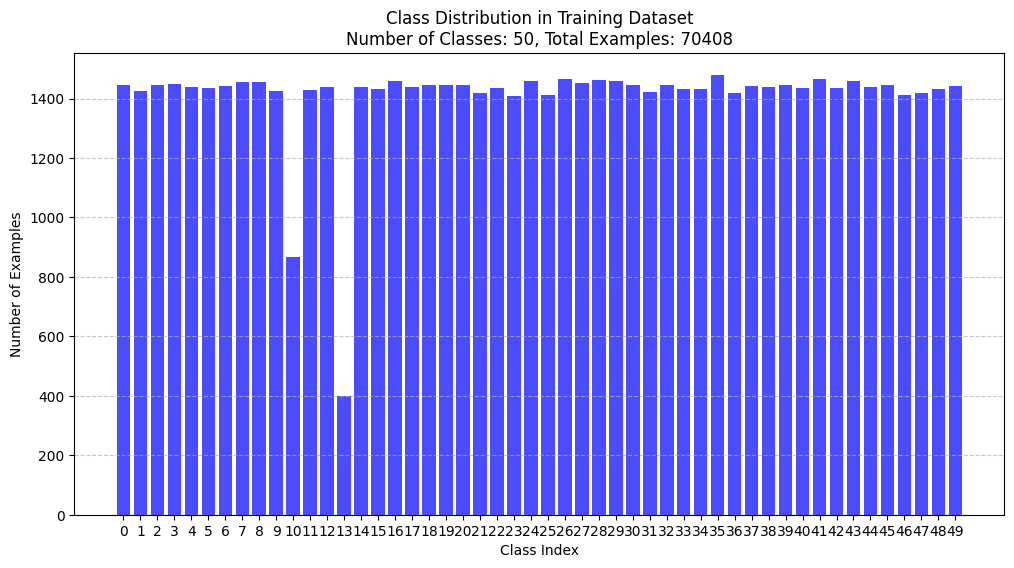

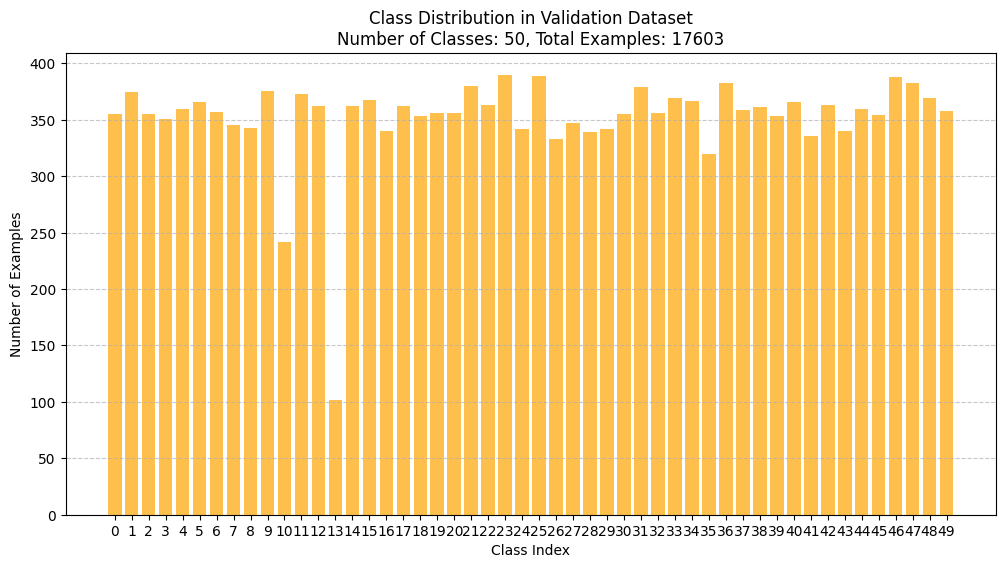

In [38]:
import matplotlib.pyplot as plt
from collections import Counter

train_class_counts = Counter(trainset.targets[idx] for idx in train_indices)
valid_class_counts = Counter(validset.targets[idx] for idx in valid_indices)

# Calculate stats for training dataset
train_num_classes = len(train_class_counts)
train_total_examples = sum(train_class_counts.values())

# Calculate stats for validation dataset
valid_num_classes = len(valid_class_counts)
valid_total_examples = sum(valid_class_counts.values())

# Plot distribution for training dataset
plt.figure(figsize=(12, 6))
plt.bar(train_class_counts.keys(), train_class_counts.values(), color='blue', alpha=0.7)
plt.title(f"Class Distribution in Training Dataset\n"
          f"Number of Classes: {train_num_classes}, Total Examples: {train_total_examples}")
plt.xlabel("Class Index")
plt.ylabel("Number of Examples")
plt.xticks(range(len(train_class_counts.keys())))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot distribution for validation dataset
plt.figure(figsize=(12, 6))
plt.bar(valid_class_counts.keys(), valid_class_counts.values(), color='orange', alpha=0.7)
plt.title(f"Class Distribution in Validation Dataset\n"
          f"Number of Classes: {valid_num_classes}, Total Examples: {valid_total_examples}")
plt.xlabel("Class Index")
plt.ylabel("Number of Examples")
plt.xticks(range(len(valid_class_counts.keys())))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Training Dataset:


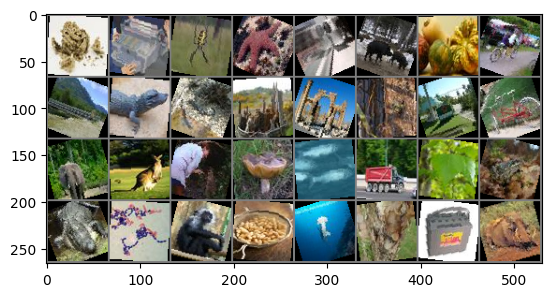

Labels: tensor([32, 36, 40, 18, 12, 43, 42,  6, 11, 17, 17, 49, 29, 23, 33,  6, 20, 28,
        28, 24, 21, 47,  7, 23, 17,  2, 30,  4, 21,  7,  3, 43])
Validation Dataset:


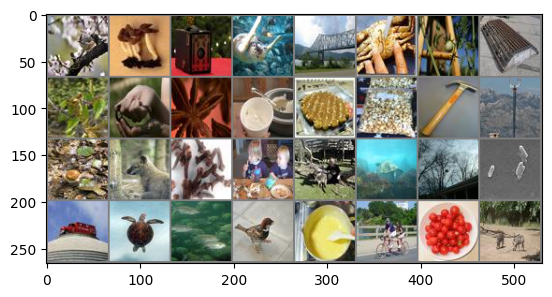

Labels: tensor([ 8, 24, 12, 48, 11, 16, 45, 11,  7, 38, 39, 27, 10, 15, 26, 25, 24, 28,
        39, 16, 28, 48, 25,  2, 47, 48, 21,  8, 27,  6, 45, 43])


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Visualize one batch from the training dataset
print("Training Dataset:")
train_images, train_labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(train_images))
print("Labels:", train_labels)

# Visualize one batch from the validation dataset
print("Validation Dataset:")
valid_images, valid_labels = next(iter(validloader))
imshow(torchvision.utils.make_grid(valid_images))
print("Labels:", valid_labels)

In [55]:
class Net(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(1024, 256)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(256, 50)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        # x = self.global_pool(x)
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


net = Net().to(device)
net

Net(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, ker

In [40]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ImprovedNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initial conv layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Residual blocks with increasing channels
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        
        # Global Average Pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layers with dropout
        self.fc = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 50)
        )

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

net = ImprovedNet().to(device)

In [56]:
import torch.optim as optim

epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer,
#     max_lr=1e-3,
#     epochs=epochs,
#     steps_per_epoch=len(trainloader),
#     pct_start=0.3
# )
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

In [57]:
from torchmetrics.classification import MulticlassAccuracy

# Initialize accuracy metric
accuracy_metric = MulticlassAccuracy(num_classes=50).to(device)

def evaluate(loader, dataset_type="Validation"):
    accuracy_metric.reset()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            accuracy_metric.update(predicted, labels)
    accuracy = accuracy_metric.compute().item() * 100
    return accuracy

In [58]:
for epoch in range(epochs):
    net.train()
    running_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    scheduler.step()

    net.eval()
    train_accuracy = evaluate(trainloader, "Training")
    valid_accuracy = evaluate(validloader, "Validation")

    print(f'Epoch [{epoch + 1}/{epochs}] - Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {valid_accuracy:.2f}%')

print('Finished Training')


Epoch [1/10] - Training Accuracy: 32.17%, Validation Accuracy: 32.43%
Epoch [2/10] - Training Accuracy: 40.70%, Validation Accuracy: 40.66%


KeyboardInterrupt: 

In [44]:
torch.save(net.state_dict(), "models/improved_net_54_23_acc.pth")

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

all_labels = []
all_predictions = []

net.eval()
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network 
        outputs = net(images).cpu()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

accuracy = accuracy_score(all_labels, all_predictions)
conf_matrix = confusion_matrix(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions)

Accuracy: 0.5953


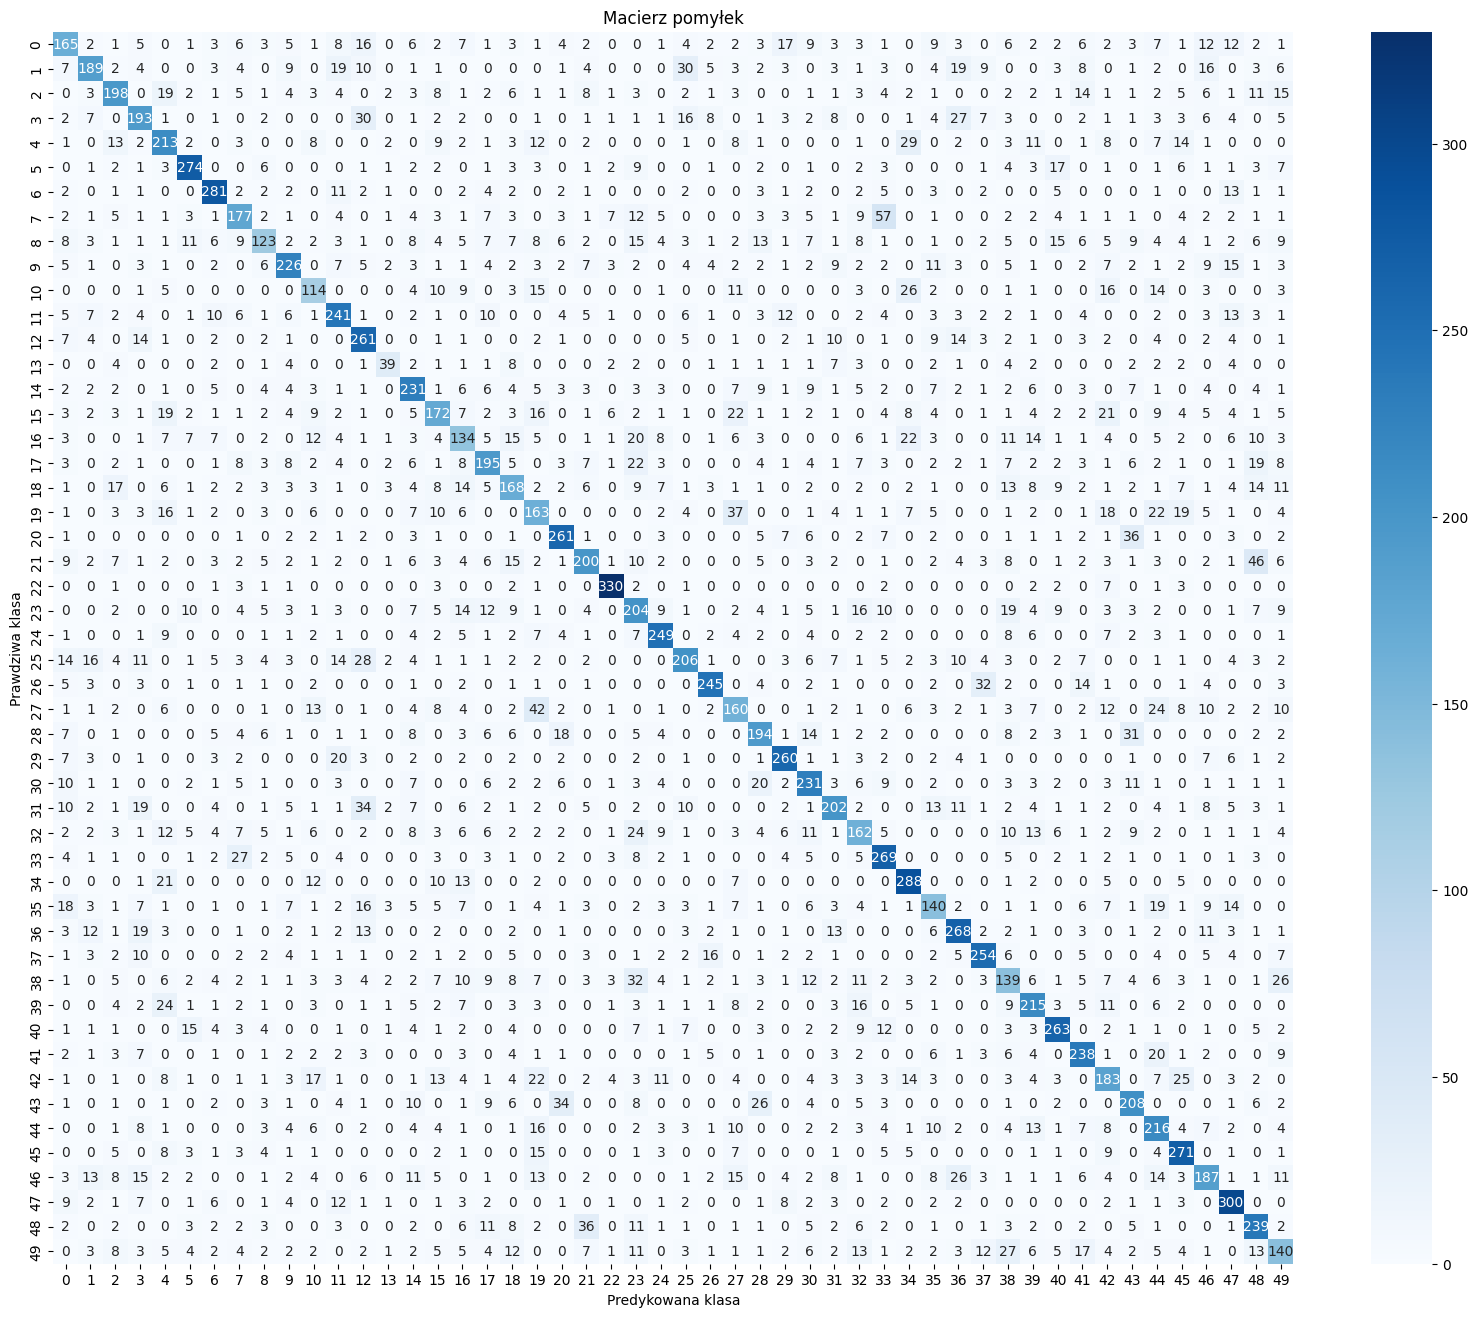

              precision    recall  f1-score   support

           0       0.50      0.46      0.48       355
           1       0.65      0.50      0.57       375
           2       0.61      0.56      0.58       355
           3       0.55      0.55      0.55       351
           4       0.53      0.59      0.56       360
           5       0.77      0.75      0.76       366
           6       0.74      0.79      0.76       357
           7       0.59      0.51      0.55       345
           8       0.54      0.36      0.43       343
           9       0.67      0.60      0.63       376
          10       0.47      0.47      0.47       242
          11       0.62      0.65      0.63       373
          12       0.58      0.72      0.64       362
          13       0.57      0.38      0.46       102
          14       0.58      0.64      0.61       362
          15       0.52      0.47      0.49       368
          16       0.42      0.39      0.41       340
          17       0.59    

In [30]:
accuracy = accuracy_score(all_labels, all_predictions)
conf_matrix = confusion_matrix(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions)

# Wyświetlenie accuracy
print(f'Accuracy: {accuracy:.4f}')

# Create a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Macierz pomyłek')
plt.xlabel('Predykowana klasa')
plt.ylabel('Prawdziwa klasa')
plt.show()

print(classification_rep)

In [56]:
test_mapping = pd.DataFrame()
for data in testloader:
    images, paths = data
    images = images.to(device)
    outputs = net(images).cpu()
    for i in range(len(paths)):
        path = paths[i]
        cl = torch.argmax(outputs[i]).item()
        img_name = path.split("/")[-1]
        new_row = pd.DataFrame({"img": [img_name], "cl": [cl]})
        test_mapping = pd.concat([test_mapping, new_row], ignore_index=True)

test_mapping.to_csv("pred.csv",index=False, header=False)